<a href="https://www.kaggle.com/code/muhammadnadhifn/2024-flame-ai-challenge-convlstm?scriptVersionId=203071625" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Copy of version 81 (best score).
<br>
Autoregressive model based on ConvLSTM using 5 input window to predict 20 target window.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Written by Bassem Akoush
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm  # Import tqdm for progress bar
from matplotlib.animation import FuncAnimation
from IPython.display import Image


#### INSTRUCTIONS FOR I/O (PLEASE READ) #######
# Input data files are available in the read-only "../input/" (relative) or '/kaggle/input'(absolute) directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
input_path = '/kaggle/input/2024-flame-ai-challenge/dataset/'
output_path = '/kaggle/working/'

# Load Metadata

**Define variable and function for loading train data**

In [2]:
train_df = pd.read_csv(os.path.join(input_path,'train.csv'))
train_df.head()

,id,u,alpha,Nt,Nx,Ny,theta_filename,ustar_filename,xi_filename
0,804025,2,10,150,113,32,theta_K_id804025.dat,ustar_ms-1_id804025.dat,xi_id804025.dat
1,875935,2,5,150,113,32,theta_K_id875935.dat,ustar_ms-1_id875935.dat,xi_id875935.dat
2,930086,6,0,150,113,32,theta_K_id930086.dat,ustar_ms-1_id930086.dat,xi_id930086.dat
3,661713,4,5,150,113,32,theta_K_id661713.dat,ustar_ms-1_id661713.dat,xi_id661713.dat
4,633229,2,0,150,113,32,theta_K_id633229.dat,ustar_ms-1_id633229.dat,xi_id633229.dat


In [3]:
def load_dataX(idx):
    csv_file = train_df.reset_index().to_dict(orient='list')
    dir_path = os.path.join(input_path, "train")
    id = csv_file['id'][idx]
    nt, Nx, Ny = csv_file['Nt'][idx], csv_file['Nx'][idx], csv_file['Ny'][idx]
    
    # Load data for all channels
    theta = np.fromfile(os.path.join(dir_path, csv_file['theta_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, csv_file['ustar_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, csv_file['xi_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    
    # Other parameters
    uin = np.full_like(theta, np.array(csv_file['u'][idx]))
    alpha = np.full_like(theta, np.array(csv_file['alpha'][idx]))
    
    # Stack all features together
    X = np.stack([xi_f, theta, ustar, uin, alpha], axis=-1)
    
    return X

This code load all data and create min max values for each channel for normalization. Normalization will be done by scaling the values within range 0 to 1 and calculate separately for each channel or features data.

In [4]:
all_data = []

for idx in range(len(train_df)):
    all_data.append(load_dataX(idx))
    
all_data = np.array(all_data)

In [5]:
# Get the number of channels
num_channels = all_data.shape[-1]

min_max_values = {}

for channel in range(num_channels):
    min_val = np.min(all_data[:, :, :, :, channel])
    max_val = np.max(all_data[:, :, :, :, channel])
    min_max_values[channel] = {'min': min_val, 'max': max_val}

del all_data

In [6]:
min_max_values

{0: {'min': 0.0, 'max': 1.0},
 1: {'min': 249.68156, 'max': 668.0308},
 2: {'min': -4.351627, 'max': 31.671425},
 3: {'min': 2.0, 'max': 6.0},
 4: {'min': 0.0, 'max': 10.0}}

# Create Dataset

This code creates a dataset for a deep learning model using time-series data with multiple spatial and channel dimensions. The goal is to generate input-output pairs from a 5-dimensional dataset, X, which has dimensions (n, time, Nx, Ny, c), where:

n: The number of sample data.<br>
time: The number of time steps in the dataset.<br>
Nx and Ny: The spatial dimensions of each time step.<br>
c: The number of channels for each spatial point.<br>

In [7]:
def create_dataset(X, window_size=1, window_target=1):
    num_samples = X.shape[0] - (window_size+window_target)  # Number of samples you can create
    Nx, Ny, c = X.shape[1:4]  # Get the spatial dimensions and number of channels

    X_data = []
    y_data = []
    y_target = []

    for i in range(num_samples):
        # Input is all channels at time t
        X_seq = X[i:i+window_size, :, :, :]  # (Nx, Ny, c) at time t
        X_data.append(X_seq)

        # Target is all channels at time t+1
        y_seq = X[i+window_size:(i+window_size)+window_target, :, :, :]  # (Nx, Ny, c) at time t+1
        y_data.append(y_seq)

    return np.array(X_data), np.array(y_data)

# Example: Iterate over all training examples
all_X_data = []
all_y_data = []

for idx in range(len(train_df)):
    X = load_dataX(idx)  # Load the data for the current index
    num_channels = X.shape[-1]
    # Normalize each channel independently
    for channel in range(num_channels):
        min_val = min_max_values[channel]['min']
        max_val = min_max_values[channel]['max']
        X[:, :, :, channel] = (X[:, :, :, channel] - min_val) / (max_val - min_val + 1e-6)  # Add a small constant to avoid division by zero
    X_seq, y_seq = create_dataset(X, window_size=5, window_target=20)  # Create inputs and targets
    
    all_X_data.append(X_seq)  # Append to the overall dataset
    all_y_data.append(y_seq)

# Concatenate all data into final arrays
all_X_data = np.concatenate(all_X_data, axis=0)
all_y_data = np.concatenate(all_y_data, axis=0)

print("Final Input shape:", all_X_data.shape)  # (num_samples, Nx, Ny, c)
print("Final Target shape:", all_y_data.shape)  # (num_samples, Nx, Ny, c)

Final Input shape: (1125, 5, 113, 32, 5)
Final Target shape: (1125, 20, 113, 32, 5)


# Modelling

In [8]:
def create_model():
    inputs = layers.Input(shape=(5, 113, 32, 5))  # Input shape: (time_steps, Nx, Ny, channels)
    
    # Encoder ConvLSTM layers for input sequence (5 time steps, 5 channels)
    x = layers.ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(inputs)
    
    # Stack more ConvLSTM layers (optional)
    x = layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True)(x)
    x = layers.ConvLSTM2D(128, (3, 3), padding='same', return_sequences=False)(x)

    
    # Reshape the 4D output (batch_size, height, width, channels) to 2D (batch_size, features)
    x = layers.Reshape((113 * 32 * 128,))(x)  # Flatten the spatial dimensions
    
    # Use RepeatVector to expand the time dimension from 5 to 20
    x = layers.RepeatVector(20)(x)  # Now the shape is (batch_size, 20, features)
    
    # Reshape back to 4D (batch_size, time_steps, height, width, channels)
    x = layers.Reshape((20, 113, 32, 128))(x)  # Reshape to match the time steps and spatial dims
    
    # Decoder ConvLSTM layer for generating 20 time steps of output
    x = layers.ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True)(x)
    x = layers.ConvLSTM2D(32, (3, 3), padding='same', return_sequences=True)(x)
    
    # Since channel 4 & 5 always same, were not predicting them
    # Final TimeDistributed Conv2D to generate the output with (113, 32, 3) spatial dimensions (3 channels)
    output_features = layers.TimeDistributed(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))(x) # 3 output channels
    
    # Create a tensor for the fourth and fifth channels from the input
    skip_channel = layers.Lambda(lambda x: x[:, :, :, :, 3:5])(inputs)  # Take channels 4 and 5 from the input
    
    # Repeat the skip channels to match the output features' time steps
    skip_channel = layers.Lambda(lambda x: tf.repeat(x, repeats=4, axis=1))(skip_channel)

    # Concatenate with the repeated skip channel
    outputs = layers.Concatenate(axis=-1)([output_features, skip_channel])
    
    # Create and compile the model
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model
    
model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 113,    │          0 │ -                 │
│ (InputLayer)        │ 32, 5)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 113,    │     42,752 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 113,    │    221,440 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_2       │ (None, 113, 32,   │    885,248 │ conv_lstm2d_1[0]… │
│ (ConvLSTM2D)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 462848)    │          0 │ conv_lstm2d_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 20,        │          0 │ reshape[0][0]     │
│ (RepeatVector)      │ 462848)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 20, 113,   │          0 │ repeat_vector[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_3       │ (None, 20, 113,   │    442,624 │ reshape_1[0][0]   │
│ (ConvLSTM2D)        │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_4       │ (None, 20, 113,   │    110,720 │ conv_lstm2d_3[0]… │
│ (ConvLSTM2D)        │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5, 113,    │          0 │ input_layer[0][0] │
│                     │ 32, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 20, 113,   │        867 │ conv_lstm2d_4[0]… │
│ (TimeDistributed)   │ 32, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 20, 113,   │          0 │ lambda[0][0]      │
│                     │ 32, 2)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 20, 113,   │          0 │ time_distributed… │
│ (Concatenate)       │ 32, 5)            │            │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,703,651 (6.50 MB)

 Trainable params: 1,703,651 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=7,
                               restore_best_weights=True,
                               min_delta=0.00001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              min_delta=0.00001)

history = model.fit(all_X_data, all_y_data, 
                    epochs=1000,
                    batch_size=8, 
                    callbacks=[early_stopping, reduce_lr],
                    verbose=2, 
                    shuffle=True,
                    validation_split=0.2)

# Load model (optional, if model already trained)
# model.load_weights('model_weights.weights.h5')

Epoch 1/1000


I0000 00:00:1729770295.894457      93 service.cc:145] XLA service 0x55f6c1203340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729770295.894544      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729770305.506921      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_3', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1729770305.530643      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1729770357.159870      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion_5', 8 bytes spill stores, 8 bytes spill loads



113/113 - 80s - 710ms/step - loss: 0.0096 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 2/1000
113/113 - 46s - 411ms/step - loss: 0.0071 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 3/1000
113/113 - 46s - 411ms/step - loss: 0.0071 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 4/1000
113/113 - 46s - 411ms/step - loss: 0.0070 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 5/1000
113/113 - 46s - 411ms/step - loss: 0.0070 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 6/1000
113/113 - 46s - 411ms/step - loss: 0.0070 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 7/1000
113/113 - 46s - 411ms/step - loss: 0.0070 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 8/1000
113/113 - 46s - 411ms/step - loss: 0.0071 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 9/1000
113/113 - 46s - 411ms/step - loss: 0.0067 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 10/1000
113/113 - 46s - 411ms/step - loss: 0.0057 - val_loss: 0.0090 - learning_rate: 0.0010
Epoch 11/1000
113/113 - 46s - 41

In [10]:
model.save_weights('model_weights.weights.h5')

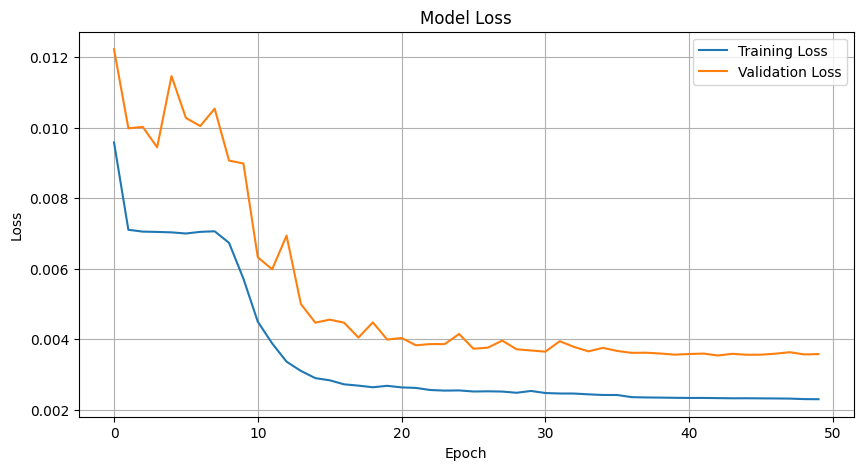

In [11]:
# Plotting training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

# Evaluate

**Evalueate MSE and MAE for fire line prediction**

In [12]:
# Assume all_X_data and all_y_data are already defined
n_sample = 100
n_steps = 1

# Initialize variables to accumulate errors
total_mse = 0
total_mae = 0

# Use tqdm to display a progress bar for the loop
for idx in tqdm(range(n_sample), desc="Processing Samples"):
    input_x = all_X_data[idx]
    y_target = all_y_data[idx:idx+n_steps, :, :, :, 0]  # Get the true target sequence
    y_pred = []

    for i in range(n_steps):
        pred = model.predict(tf.expand_dims(input_x, axis=0), verbose=0)
        input_x = pred[0]         # Insert the new prediction at the end
        y_pred.append(pred[0,:,:,:,0])

    # Flatten arrays to compare them correctly
    y_pred = np.array(y_pred).flatten()
    y_target = y_target.flatten()

    # Calculate MSE and MAE for the current sample
    mse = mean_squared_error(y_target, y_pred)
    mae = mean_absolute_error(y_target, y_pred)

    # Accumulate the errors
    total_mse += mse
    total_mae += mae

# Calculate the average MSE and MAE across all samples
average_mse = total_mse / n_sample
average_mae = total_mae / n_sample

print("Average MSE:", average_mse) # 0.02406
print("Average MAE:", average_mae) # 0.04567

Processing Samples: 100%|██████████| 100/100 [00:10<00:00,  9.47it/s]

Average MSE: 0.008078252607956528
Average MAE: 0.016903079091571273


**Comparing fire line prediction with the ground truth**

In [13]:
channel_to_view = 0  # 0 -> fire line
n_time = 12 
idx_to_view = 111

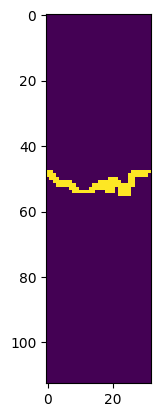

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


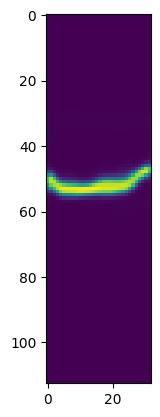

In [14]:
plt.imshow(all_y_data[idx_to_view, n_time, :, :, channel_to_view])
plt.show()

y_pred = model.predict(tf.expand_dims(all_X_data[idx_to_view], axis=0))
plt.imshow(y_pred[0, n_time, :, :, channel_to_view])
plt.show()

# Prediction

In [15]:
test_df = pd.read_csv(os.path.join(input_path,'test.csv'))
test_df.head()

,id,u,alpha,Nt,Nx,Ny,theta_filename,ustar_filename,xi_filename
0,219547,5,2.5,5,113,32,theta_K_id219547.dat,ustar_ms-1_id219547.dat,xi_id219547.dat
1,167403,5,2.5,5,113,32,theta_K_id167403.dat,ustar_ms-1_id167403.dat,xi_id167403.dat
2,225258,5,2.5,5,113,32,theta_K_id225258.dat,ustar_ms-1_id225258.dat,xi_id225258.dat
3,890407,5,25.0,5,113,32,theta_K_id890407.dat,ustar_ms-1_id890407.dat,xi_id890407.dat
4,352206,5,25.0,5,113,32,theta_K_id352206.dat,ustar_ms-1_id352206.dat,xi_id352206.dat


In [16]:
#gets test set input
def getTestX(idx):
    csv_file = test_df.reset_index().to_dict(orient='list')
    dir_path = os.path.join(input_path, "test")
    
    id = csv_file['id'][idx]
    nt, Nx, Ny = csv_file['Nt'][idx], csv_file['Nx'][idx], csv_file['Ny'][idx]
    
    theta = np.fromfile(os.path.join(dir_path, csv_file['theta_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, csv_file['ustar_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, csv_file['xi_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    
    # Other parameters
    uin = np.full_like(theta, np.array(csv_file['u'][idx]))
    alpha = np.full_like(theta, np.array(csv_file['alpha'][idx]))
    
    # Stack all features together
    X = np.stack([xi_f, theta, ustar, uin, alpha], axis=-1)

    return id, X


#predicts with input
def predict(idx,model):
    id,X = getTestX(idx)
    for channel in range(num_channels):
        min_val = min_max_values[channel]['min']
        max_val = min_max_values[channel]['max']
        X[:, :, :, channel] = (X[:, :, :, channel] - min_val) / (max_val - min_val + 1e-6)  # Add a small constant to avoid division by zero
    y_pred = model(X)
    return id,y_pred

from tqdm import tqdm

#generates submission with model predictions already in SI units
def generate_submission(model):
    y_preds = {}
    ids = []
    for idx in tqdm(range(len(test_df))):
        id, y_pred = predict(idx, model) 
        #WARNING tmp should be in SI units
        y_preds[id]= np.array(y_pred).flatten(order='C').astype(np.float32)
        ids.append(id)
    df = pd.DataFrame.from_dict(y_preds,orient='index')
    df['id'] = ids

    #move id to first column
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    #reset index
    df = df.reset_index(drop=True)

    return df

**Define model to do autoregressive prediction**

In [17]:
class FireSpreadModel(tf.keras.Model):
    def __init__(self, pre_trained_model, n_predictions=1):
        super(FireSpreadModel, self).__init__()
        self.pre_trained_model = pre_trained_model
        self.n_predictions = n_predictions

    def call(self, initial_data):
        predictions = []
        current_data = tf.expand_dims(initial_data, axis=0)  # Ensure batch dimension (1, time_steps, Nx, Ny, channels)
        # current_data = tf.convert_to_tensor(current_data, dtype=tf.float32)  # Convert to tensor if needed

        for _ in range(self.n_predictions):
            pred = self.pre_trained_model(current_data)
            pred = tf.squeeze(pred, axis=0)  # Remove the batch dimension

            # Save the prediction (Channel 0: Fire)
            predictions.append(pred[:, :, :, 0])

            # Prepare the input for the next step
            # Take last 5 data from prediction as new input
            current_data = tf.expand_dims(pred[-(current_data.shape[1]):], axis=0)

        # Stack the predictions along a new axis (n_predictions, time_steps, Nx, Ny)
        predictions = tf.stack(predictions, axis=0)

        # Reshape to (20, 113, 32)
        predictions_reshaped = tf.reshape(predictions, (predictions.shape[0]*predictions.shape[1], 113, 32))
        
        return predictions_reshaped


**Predicting and create submission**

In [18]:
fire_model = FireSpreadModel(model, n_predictions=1)

# predict(0, loaded_model)
df = generate_submission(fire_model)
df.to_csv(os.path.join(output_path, 'submission.csv'),index=False)
print('Generating Submission file ... completed' )

100%|██████████| 27/27 [00:14<00:00,  1.81it/s]


Generating Submission file ... completed


**Sampel of prediction result.**

In [19]:
idx = 7
fire_model = FireSpreadModel(model, n_predictions=4)

In [20]:
_, test_data = getTestX(idx)
test_data = test_data[:, :, :, 0] 

_, test_pred = predict(idx, fire_model)
test_pred = np.array(test_pred)

test_pred = np.concatenate([test_data, test_pred], axis=0)

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize the image with the first frame
im = ax.imshow(test_pred[0, :, :], cmap='hot', interpolation='nearest')

# Add text element for frame number
frame_text = ax.text(0.5, -0.1, '', transform=ax.transAxes, ha='center', fontsize=12, color='black')

# Update function for the animation
def update(frame):
    im.set_array(test_pred[frame, :, :])
    
    # Update the frame number text
    frame_text.set_text(f'Frame: {frame + 1}/{test_pred.shape[0]}')
    
    return [im, frame_text]

# Create the animation with an interval
ani = FuncAnimation(fig, update, frames=range(test_pred.shape[0]), interval=200, blit=True)

# Save the animation as a GIF file
ani.save('animation.gif', writer='imagemagick')

# Close the figure to prevent showing the last frame
plt.close(fig)

# Display the GIF in the notebook
Image(url='animation.gif')